<img src="../../images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px\" align="left">

## Quantum Volume
---

* **Last Updated:** May 31, 2019
* **Requires:** qiskit-terra 0.8, qiskit-ignis 0.1.1, qiskit-aer 0.2


## Introduction

**Quantum Volume (QV)** is a method to verify device performance and a metric to quantify the computational power of a quantum device.  The method is based on the paper "Validating quantum computers using randomized model circuits" (https://arxiv.org/abs/1811.12926). 

This notebook gives an example for how to use the ``ignis.verification.quantum_volume`` module. This particular example shows how to run up to depth 6 quantum volume circuits and will run them using the noisy Aer simulator.

In [1]:
#Import general libraries (needed for functions)
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

#Import Qiskit classes classes
import qiskit
import qiskit.providers.aer.noise as noise
from qiskit.transpiler.coupling import CouplingMap

#Import the qv function.
import qiskit.ignis.verification.quantum_volume as qv

### Load IBMQ accounts and grab target device backend

To illustrate QV we will use a real backend for transpiling

In [2]:
qiskit.IBMQ.load_accounts()
backend = qiskit.IBMQ.get_backend('ibmq_16_melbourne')
print('Device has:', backend.configuration().n_qubits, 'qubits')

Device has: 14 qubits


## Select the Parameters of the QV Run

There are two ways to generate volume circuits. Option 1 is to specify explicit sets of qubits. The other way is to specify a list of widths. This will create circuits on the first `n` qubits which we will then map to the qubits of choice.

In this example we have 6 qubits Q4,Q5,Q6,Q10,Q8,Q9. We are going to look at subsets up to the full set.

In [3]:
#Qubit list
qubit_lists = [[4,5],[4,5,6],[4,5,6,10],[4,5,6,10,8],[4,5,6,10,8,9]]
width_list = [2,3,4,5,6]
ntrials = 50

#select which option to use for the actual simulation
qv_opt=1

## Generate QV sequences

We generate the quantum volume sequences. We will look at both ways for generating the circuits. 

### Option 1: Explictly specify Qubits

In [4]:
qv_circs, qv_circs_nomeas = qv.qv_circuits(qubit_lists=qubit_lists, ntrials=ntrials)

Before transpiling the circuit has been created using random SU(4) unitaries on the subset defined in qubit_lists.

In [5]:
print(qv_circs[0][0])

                                       
qr_0: |0>──────────────────────────────
                                       
qr_1: |0>──────────────────────────────
                                       
qr_2: |0>──────────────────────────────
                                       
qr_3: |0>──────────────────────────────
         ┌──────────┐┌──────────┐┌─┐   
qr_4: |0>┤0         ├┤1         ├┤M├───
         │  unitary ││  unitary │└╥┘┌─┐
qr_5: |0>┤1         ├┤0         ├─╫─┤M├
         └──────────┘└──────────┘ ║ └╥┘
 cr_0: 0 ═════════════════════════╩══╬═
                                     ║ 
 cr_1: 0 ════════════════════════════╩═
                                       


Transpiling will replace the random unitaries with the equivalent unitary decomposed into the standard gateset but there will be no mapping

In [6]:
#pass the first trial of the nomeas through the transpiler to illustrate the circuit
qv_circs[0][0] = qiskit.compiler.transpile(qv_circs[0][0], backend=backend)

In [7]:
print(qv_circs[0][0])

                                                                              »
 q_0: |0>─────────────────────────────────────────────────────────────────────»
                                                                              »
 q_1: |0>─────────────────────────────────────────────────────────────────────»
                                                                              »
 q_2: |0>─────────────────────────────────────────────────────────────────────»
                                                                              »
 q_3: |0>─────────────────────────────────────────────────────────────────────»
          ┌──────────────────────────┐┌───┐┌────────────────────────────┐┌───┐»
 q_4: |0>─┤ U3(1.6669,2.1688,1.5112) ├┤ X ├┤ U3(0.51529,-3.1416,3.1416) ├┤ X ├»
         ┌┴──────────────────────────┤└─┬─┘├───────────────────────────┬┘└─┬─┘»
 q_5: |0>┤ U3(2.265,-2.3559,-3.0502) ├──■──┤ U3(1.5708,-1.0541,4.7124) ├───■──»
         └───────────────────────────┘  

### Option 2: Specify widths

By specifying just the widths of the sets we get a set of more universal circuits that can be mapped to an arbitrary set of qubits

In [8]:
qv_circs2, qv_circs_nomeas2 = qv.qv_circuits(width_list=width_list, ntrials=ntrials)

The circuits are created on the first `n` qubits as random unitaries

In [9]:
print(qv_circs2[0][0])

         ┌──────────┐┌──────────┐┌─┐   
qr_0: |0>┤1         ├┤1         ├┤M├───
         │  unitary ││  unitary │└╥┘┌─┐
qr_1: |0>┤0         ├┤0         ├─╫─┤M├
         └──────────┘└──────────┘ ║ └╥┘
 cr_0: 0 ═════════════════════════╩══╬═
                                     ║ 
 cr_1: 0 ════════════════════════════╩═
                                       


We can then transpile these circuits to the set of qubits as desired

In [10]:
#pass the first trial of the nomeas through the transpiler to illustrate the circuit
qv_circs2b = qiskit.compiler.transpile(qv_circs2[0], 
                                           basis_gates=['u1','u2','u3','cx'],
                                           backend=backend,
                                           initial_layout=qubit_lists,optimization_level=0)

In [11]:
# NOTE: These should be on qubits 4 and 5
print(qv_circs2b[0])

                ┌────────────────────────────┐┌───┐»
      qr_0: |0>─┤ U3(1.5946,0.92599,-3.9983) ├┤ X ├»
               ┌┴────────────────────────────┤└─┬─┘»
      qr_1: |0>┤ U3(0.85792,-3.1215,-2.4333) ├──■──»
               └─────────────────────────────┘     »
 ancilla_0: |0>────────────────────────────────────»
                                                   »
 ancilla_1: |0>────────────────────────────────────»
                                                   »
 ancilla_2: |0>────────────────────────────────────»
                                                   »
 ancilla_3: |0>────────────────────────────────────»
                                                   »
 ancilla_4: |0>────────────────────────────────────»
                                                   »
 ancilla_5: |0>────────────────────────────────────»
                                                   »
 ancilla_6: |0>────────────────────────────────────»
                                              

## Simulate the ideal circuits

The quantum volume method requires that we know the ideal output for each circuit, so use the statevector simulator in Aer to get the ideal result.

In [12]:
#The Unitary is an identity (with a global phase)
backend_sim = qiskit.Aer.get_backend('statevector_simulator')
ideal_results = []
for trial in range(ntrials):
    print('Simulating trial %d'%trial)
    if qv_opt==1:
        ideal_results.append(qiskit.execute(qv_circs_nomeas[trial], backend=backend_sim).result())
    else:
        ideal_results.append(qiskit.execute(qv_circs_nomeas2[trial], backend=backend_sim).result())


Simulating trial 0
Simulating trial 1
Simulating trial 2
Simulating trial 3
Simulating trial 4
Simulating trial 5
Simulating trial 6
Simulating trial 7
Simulating trial 8
Simulating trial 9
Simulating trial 10
Simulating trial 11
Simulating trial 12
Simulating trial 13
Simulating trial 14
Simulating trial 15
Simulating trial 16
Simulating trial 17
Simulating trial 18
Simulating trial 19
Simulating trial 20
Simulating trial 21
Simulating trial 22
Simulating trial 23
Simulating trial 24
Simulating trial 25
Simulating trial 26
Simulating trial 27
Simulating trial 28
Simulating trial 29
Simulating trial 30
Simulating trial 31
Simulating trial 32
Simulating trial 33
Simulating trial 34
Simulating trial 35
Simulating trial 36
Simulating trial 37
Simulating trial 38
Simulating trial 39
Simulating trial 40
Simulating trial 41
Simulating trial 42
Simulating trial 43
Simulating trial 44
Simulating trial 45
Simulating trial 46
Simulating trial 47
Simulating trial 48
Simulating trial 49


Next, load the ideal results into a quantum volume fitter

In [13]:
qv_fitter = qv.QVFitter(qubit_lists=qubit_lists)
qv_fitter.add_statevectors(ideal_results)

## Define the noise model

We define a noise model for the simulator using the noise model from the device.

In [14]:
noise_model = noise.device.basic_device_noise_model(backend.properties())
basis_gates = noise_model.basis_gates

#For option 2 circuits we can do the noise simulation and transpiling by reducing the 
#coupling map and noise model down to the first n qubits
red_cmap = CouplingMap(backend.configuration().coupling_map).reduce(qubit_lists[-1])
red_noise_model = noise.utils.remap_noise_model(noise_model,
                                                remapping=qubit_lists[-1],
                                                discard_qubits=True)
if qv_opt==2:
    noise_model=red_noise_model

## Execute on Aer simulator

We can execute the QV sequences either using Qiskit Aer Simulator (with some noise model) or using IBMQ provider, 
and obtain a list of results **result_list**.

In [15]:
backend_sim = qiskit.Aer.get_backend('qasm_simulator')
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
shots = 1024
exp_results = []
for trial in range(len(qv_circs)):
    print('Running trial %d'%trial)
    #we need to transpile the qubits for the device
    if qv_opt==1:
        qv_circs[trial] = qiskit.compiler.transpile(qv_circs[trial], basis_gates=basis_gates,
                                               backend=backend)
    else:
        #if option 2 use the reduced coupling map
        #but no backend
        qv_circs[trial] = qiskit.compiler.transpile(qv_circs2[trial], basis_gates=basis_gates,
                                               coupling_map=red_cmap)
    
    
    exp_results.append(qiskit.execute(qv_circs[trial], 
                                      basis_gates=basis_gates, 
                                      backend=backend_sim, 
                                      noise_model=noise_model, 
                                      backend_options={'max_parallel_experiments': 0}).result())

Running trial 0
Running trial 1
Running trial 2
Running trial 3
Running trial 4
Running trial 5
Running trial 6
Running trial 7
Running trial 8
Running trial 9
Running trial 10
Running trial 11
Running trial 12
Running trial 13
Running trial 14
Running trial 15
Running trial 16
Running trial 17
Running trial 18
Running trial 19
Running trial 20
Running trial 21
Running trial 22
Running trial 23
Running trial 24
Running trial 25
Running trial 26
Running trial 27
Running trial 28
Running trial 29
Running trial 30
Running trial 31
Running trial 32
Running trial 33
Running trial 34
Running trial 35
Running trial 36
Running trial 37
Running trial 38
Running trial 39
Running trial 40
Running trial 41
Running trial 42
Running trial 43
Running trial 44
Running trial 45
Running trial 46
Running trial 47
Running trial 48
Running trial 49


Load the experimental data into the fitter. The data will keep accumulating if this is re-run (unless the fitter is re-instantiated).

In [16]:
qv_fitter.add_data(exp_results)

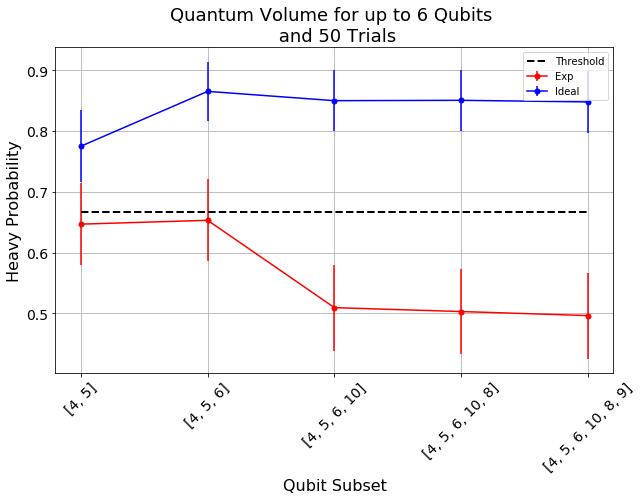

In [17]:
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Plot the essence by calling plot_rb_data
qv_fitter.plot_qv_data(ax=ax, show_plt=False)

# Add title and label
ax.set_title('Quantum Volume for up to %d Qubits \n and %d Trials'%(len(qubit_lists[-1]), ntrials), fontsize=18)

plt.show()

## Quantum Volume
List statistics for each depth. For each depth list if the depth was successful or not and with what confidence interval. For a depth to be sucessful the confidence interval must be > 97.5%.

In [18]:
qv_success_list = qv_fitter.qv_success()
qv_list = qv_fitter.ydata
for qidx, qubit_list in enumerate(qubit_lists):
    if qv_list[0][qidx]>2/3:
        if qv_success_list[qidx][0]:
            print("Width/depth %d greater than 2/3 (%f) with confidence %f (successful). Quantum volume %d"%
                  (len(qubit_list),qv_list[0][qidx],qv_success_list[qidx][1],qv_fitter.quantum_volume()[qidx]))
        else:
            print("Width/depth %d greater than 2/3 (%f) with confidence %f (unsuccessful)."%
                  (len(qubit_list),qv_list[0][qidx],qv_success_list[qidx][1]))
    else:
        print("Width/depth %d less than 2/3 (unsuccessful)."%len(qubit_list))

Width/depth 2 less than 2/3 (unsuccessful).
Width/depth 3 less than 2/3 (unsuccessful).
Width/depth 4 less than 2/3 (unsuccessful).
Width/depth 5 less than 2/3 (unsuccessful).
Width/depth 6 less than 2/3 (unsuccessful).
